# Cat vs. Dog Image Classification

1. Download data and set paths
2. Data Augmentation and modelling
3. Train Model
4. Evaluate model
5. Write into submission.csv
6. Train and evaluate CIFAR-10 Dataset

Let's go!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_checkpoint_dir = "drive/MyDrive/aiproject"

# Part 1 - Download data and set paths

Let's download datasets from the link provided!

In [ ]:
!gdown https://drive.google.com/uc?id=1q0r6yeHQMS17R3wz-s2FIbMR5DAGZK5v -O /tmp/cats_dogs_filtered.zip

Downloading...
From: https://drive.google.com/uc?id=1q0r6yeHQMS17R3wz-s2FIbMR5DAGZK5v
To: /tmp/cats_dogs_filtered.zip
100% 1.10G/1.10G [00:14<00:00, 75.4MB/s]


Unzipping it and save to /tmp

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

creating path for easier for easier execution


In [ ]:
base_dir = '/tmp/datasets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir,'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cat')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dog')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')


Curious if your path is set correctly? Let's read some of the images

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.10900.jpg', 'cat.7563.jpg', 'cat.3159.jpg', 'cat.7742.jpg', 'cat.10785.jpg', 'cat.12459.jpg', 'cat.1111.jpg', 'cat.9949.jpg', 'cat.118.jpg', 'cat.7554.jpg']
['dog.0.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10005.jpg', 'dog.10006.jpg']


Number of images of `train` and `validation` cats and dogs 

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500


Let's see some images!! WOOHOO


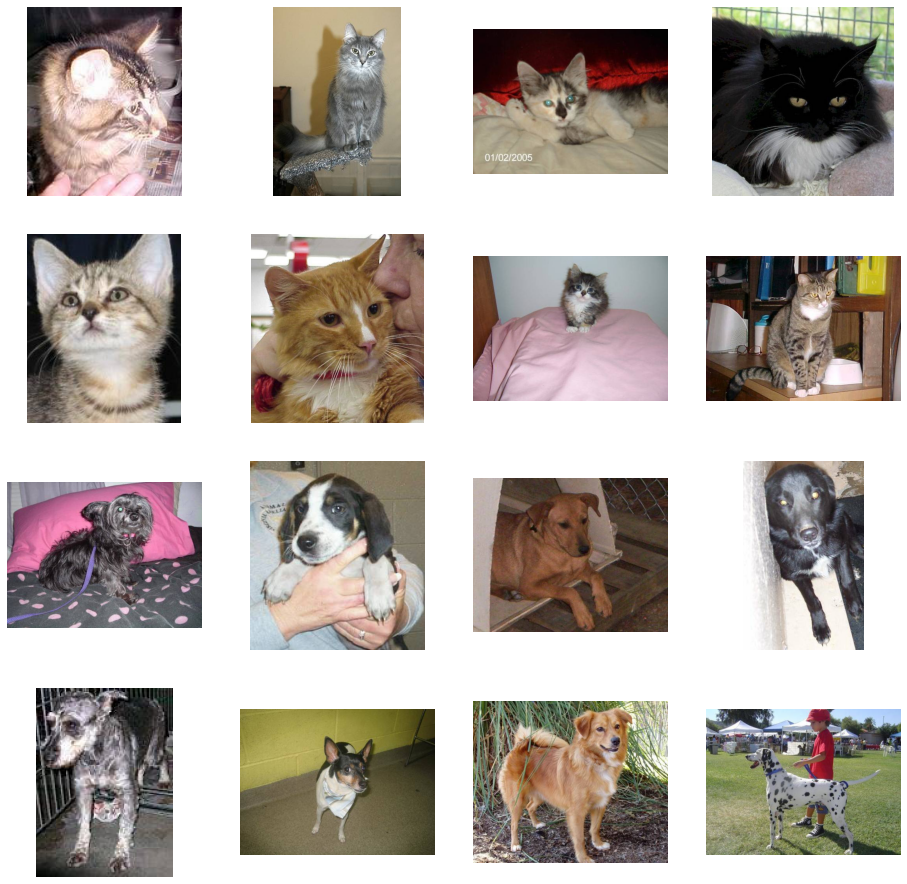

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(16,16)

pic_index = 0
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Part 2 - *Data Augmentation and modelling*


In [ ]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import tensorflow as tf

Note that Data augmentation is only use for train set

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)


Note that VGG input is (224,224,3)

In [ ]:
# VGG usage is at (224,224)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Download VGG16 pretrained model and leave the top layer as False so that we can have our own output

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 1s 0us/step


Unfreeze those layers so that you can train on them

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Set last layer few layers of output `sigmoid` as activation layer as it pairs up with binary classification problems
Loss function set as `binary_crossentropy` since its a binary classification problem

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Part 3 - Train Model with VGG16

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

Train your model! Remember to add in checkpoints to save your model!

In [ ]:
checkpoint_filepath = '/drive/MyDrive/aiproject'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 1000, epochs = 20, callbacks=[model_checkpoint_callback])

Epoch 1/20
1000/1000 [==============================] - 444s 409ms/step - loss: 0.4260 - acc: 0.8048 - val_loss: 0.2078 - val_acc: 0.9152
Epoch 2/20
1000/1000 [==============================] - 407s 407ms/step - loss: 0.3323 - acc: 0.8569 - val_loss: 0.1921 - val_acc: 0.9246
Epoch 3/20
1000/1000 [==============================] - 407s 407ms/step - loss: 0.3195 - acc: 0.8670 - val_loss: 0.2122 - val_acc: 0.9218
Epoch 4/20
1000/1000 [==============================] - 406s 406ms/step - loss: 0.3084 - acc: 0.8727 - val_loss: 0.2277 - val_acc: 0.9184
Epoch 5/20
1000/1000 [==============================] - 406s 406ms/step - loss: 0.2957 - acc: 0.8779 - val_loss: 0.1897 - val_acc: 0.9288
Epoch 6/20
1000/1000 [==============================] - 407s 407ms/step - loss: 0.2960 - acc: 0.8835 - val_loss: 0.2071 - val_acc: 0.9270
Epoch 7/20
1000/1000 [==============================] - 406s 406ms/step - loss: 0.2917 - acc: 0.8817 - val_loss: 0.1942 - val_acc: 0.9314
Epoch 8/20
1000/1000 [============

# Part 4 - Evaluate model

Text(0.5, 1.0, 'Training and validation loss')

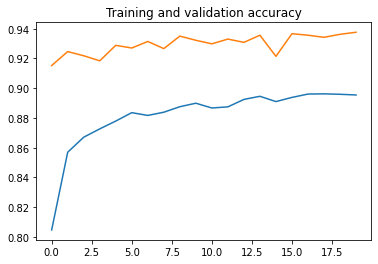

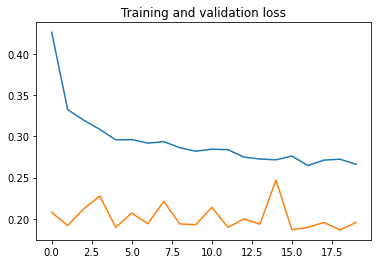

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = vgghist.history['acc']
val_acc = vgghist.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Predict with your model!

In [ ]:
# Input image filepath and convert it to numpy array for model to predict
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [ ]:
# Testing your image with VGG model
# Cat: 0 , Dog: 1
test_files = os.listdir(test_dir)
image = load(os.path.join(test_dir,test_files[1])) 

# image 490.jpg is a cat hence output should be 0, try others to test
print(os.path.join(test_dir,test_files[1]))



/tmp/datasets/test/490.jpg


In [ ]:
model.predict(image)

array([[0.03469273]], dtype=float32)

In [ ]:
print(model.predict(image)[0][0])

0.03469273


# Part 5 - Predict test images and parse into submission.csv

In [ ]:
import pandas as pd

In [ ]:
test_files = os.listdir(test_dir)
testname = []
labels = []
for i in range (1,len(test_files)+1):
  filename = test_dir + "/"+ str(i) + ".jpg"
  image = load(filename)

  if model.predict(image)[0][0] < 0.5:
    labels.append(0)
  else:
    labels.append(1)
  testname.append(str(i))

dataframe = pd.DataFrame({"id": testname, "labels": labels}, columns = ["id","labels"])
dataframe.sort_values(by=['id'], ascending=True)
dataframe.to_csv("drive/MyDrive/aiproject/submissions.csv", index = False)


# Part 6 - CIFAR-10 Datasets
Load CIFAR-10 Datasets

In [ ]:
from tensorflow.keras.utils import to_categorical
def normalization(train_images, test_images):
    mean = np.mean(train_images, axis=(0, 1, 2, 3))
    std = np.std(train_images, axis=(0, 1, 2, 3))
    train_images = (train_images - mean) / (std + 1e-7)
    test_images = (test_images - mean) / (std + 1e-7)
    return train_images, test_images


def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)

    (train_images, test_images) = normalization(train_images, test_images)

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)
    return train_images, train_labels, test_images, test_labels

train_images,train_labels, test_images, test_labels = load_images()

In [ ]:
datagen = ImageDataGenerator(rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

datagen.fit(train_images)

Usage of `categorical_crossentropy` instead of `sparse_categorical_crossentropy` as there isn't much difference for this case here however the latter takes up lesser space

In [ ]:
from tensorflow import keras
import numpy as np

class ConvBNRelu(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME', weight_decay=0.0005, rate=0.4, drop=True):
        super(ConvBNRelu, self).__init__()
        self.drop = drop
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                                        padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dropOut = keras.layers.Dropout(rate=rate)

    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = tf.nn.relu(layer)
        layer = self.batchnorm(layer)
        if self.drop:
            layer = self.dropOut(layer)

        return layer


class VGG16Model(tf.keras.Model):
    def __init__(self):
        super(VGG16Model, self).__init__()
        self.conv1 = ConvBNRelu(filters=64, kernel_size=[3, 3], rate=0.3)
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], drop=False)
        self.maxPooling1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3])
        self.conv4 = ConvBNRelu(filters=128, kernel_size=[3, 3], drop=False)
        self.maxPooling2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv5 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv6 = ConvBNRelu(filters=256, kernel_size=[3, 3])
        self.conv7 = ConvBNRelu(filters=256, kernel_size=[3, 3], drop=False)
        self.maxPooling3 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv11 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv12 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv13 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling5 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv14 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv15 = ConvBNRelu(filters=512, kernel_size=[3, 3])
        self.conv16 = ConvBNRelu(filters=512, kernel_size=[3, 3], drop=False)
        self.maxPooling6 = keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flat = keras.layers.Flatten()
        self.dropOut = keras.layers.Dropout(rate=0.5)
        self.dense1 = keras.layers.Dense(units=512,
                                         activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dense2 = keras.layers.Dense(units=10)
        self.softmax = keras.layers.Activation('softmax')

    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.conv2(net)
        net = self.maxPooling1(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.maxPooling2(net)
        net = self.conv5(net)
        net = self.conv6(net)
        net = self.conv7(net)
        net = self.maxPooling3(net)
        net = self.conv11(net)
        net = self.conv12(net)
        net = self.conv13(net)
        net = self.maxPooling5(net)
        net = self.conv14(net)
        net = self.conv15(net)
        net = self.conv16(net)
        net = self.maxPooling6(net)
        net = self.dropOut(net)
        net = self.flat(net)
        net = self.dense1(net)
        net = self.batchnorm(net)
        net = self.dropOut(net)
        net = self.dense2(net)
        net = self.softmax(net)
        return net

model_2 = VGG16Model()


In [ ]:
tf.random.set_seed(777)
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])

Note: Steps per epoch is calculate as `no. of images/batch_size`

In [ ]:
vgghist_2 = model_2.fit_generator(datagen.flow(train_images,train_labels, batch_size = 20), verbose = 2, steps_per_epoch = 2500, epochs = 10, validation_data= (test_images,test_labels))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2500/2500 - 214s - loss: 2.0942 - accuracy: 0.4954 - val_loss: 1.9519 - val_accuracy: 0.5549
Epoch 2/10
2500/2500 - 213s - loss: 1.9446 - accuracy: 0.5251 - val_loss: 1.7986 - val_accuracy: 0.6004
Epoch 3/10
2500/2500 - 213s - loss: 1.8261 - accuracy: 0.5527 - val_loss: 1.5689 - val_accuracy: 0.6361
Epoch 4/10
2500/2500 - 213s - loss: 1.7402 - accuracy: 0.5706 - val_loss: 1.5819 - val_accuracy: 0.6310
Epoch 5/10
2500/2500 - 214s - loss: 1.6623 - accuracy: 0.5906 - val_loss: 1.4218 - val_accuracy: 0.6635
Epoch 6/10
2500/2500 - 214s - loss: 1.6002 - accuracy: 0.6067 - val_loss: 1.3521 - val_accuracy: 0.6947
Epoch 7/10
2500/2500 - 214s - loss: 1.5392 - accuracy: 0.6245 - val_loss: 1.3153 - val_accuracy: 0.6997
Epoch 8/10
2500/2500 - 214s - loss: 1.4915 - accuracy: 0.6373 - val_loss: 1.3052 - val_accuracy: 0.7070
Epoch 9/10
2500/2500 - 214s - loss: 1.4561 - accuracy: 0.6498 - val_loss: 1.2429 - val_accuracy: 0.7194
Epoch 10/10
2500/2500 - 213s - loss: 1.4312 - accuracy: 0.6578 -

# Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)